<a href="https://colab.research.google.com/github/guzmanjs/MCD/blob/main/Semestre%202/Fundamentos%20Analitica%20II/Ejercicios%20en%20clase/taller1_fundamentos_de_analitica2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# Taller 1: Fundamentos de Analítica II
Luisa F. Giraldo -
Juan S. Guzman
</center>

### Enunciado del ejercicio:
Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.



In [ ]:
# Importamos los paquetes a usar

import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [ ]:
#Procedemos a la carga de los datos

data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True) #La fecha del registro queda como índice
data.tail()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2018-12-01,10.725865,10835.398,1301.822,6142.856
2019-01-01,13.739328,10314.438,1642.851,6343.066
2019-02-01,12.427409,10557.917,1498.272,6264.403
2019-03-01,11.975098,10760.776,1463.919,6116.140
2019-04-01,11.144286,10632.028,1333.469,6395.575


## 1. Análisis de la serie:

Graficamos la serie para comprender graficamente su dinámica:

(220, 4)


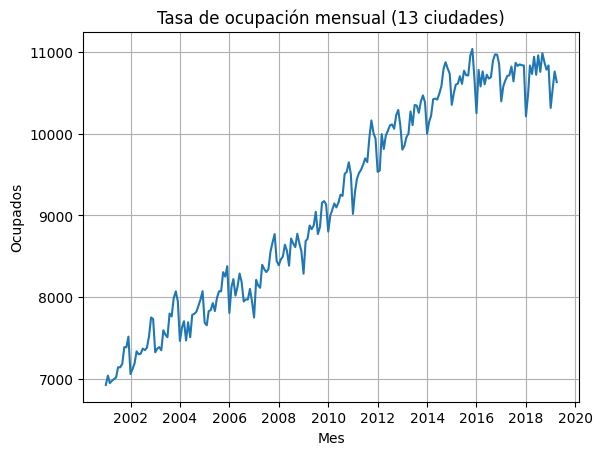

In [ ]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

Vemos que la serie tiene una tendencia creciente y parece contener cierta estacionalidad. Procedemos a descomponerla en sus distintas partes:

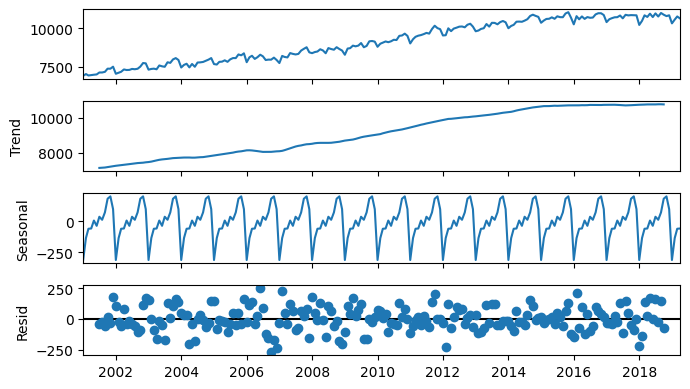

In [ ]:
#Descomposición de la serie de tiempo

td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((7, 4))
fig.tight_layout()
plt.show()

Como lo decíamos arriba, la serie presenta una tendencia creciente en el tiempo con una estacionalidad que evidencia que la ocupación crece paulatinamente en el año y se desploma al final de este; y este comportamiento se mantiene año a año.

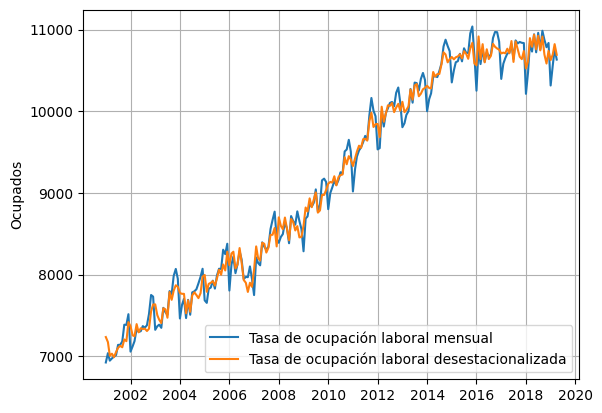

In [ ]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa de ocupación laboral mensual")
plt.plot(td_desestacionalizada,label="Tasa de ocupación laboral desestacionalizada")
plt.ylabel("Ocupados")
plt.legend()
plt.grid()
plt.show()


Al desestacionalizar la serie (gráfica naranja) vemos especialmente que las caídas en la ocupación al final del año se suavizan un poco.

## 2. Métodos de suavización

Iniciamos partiendo el data set en datos de entrenamiento y datos de prueba para afinar el modelo antes de proceder a la predicción.

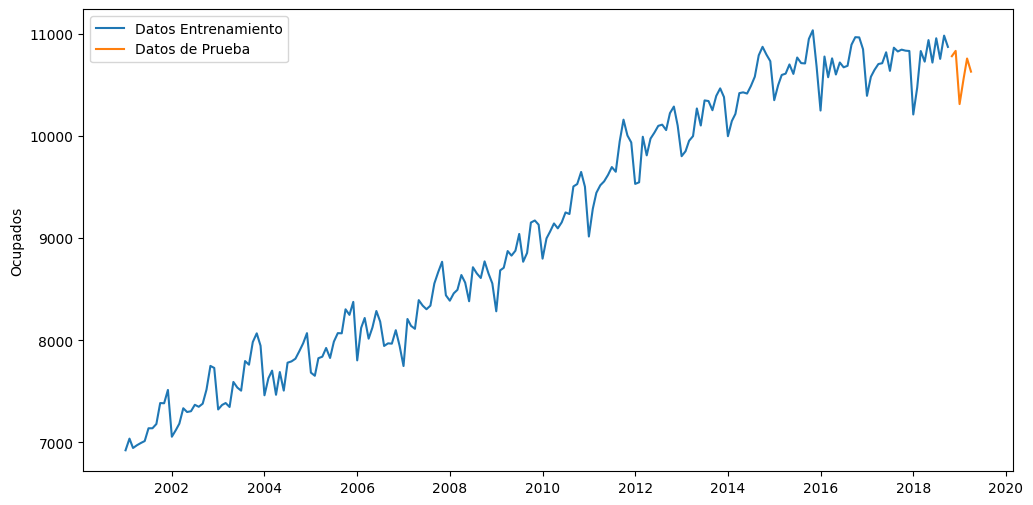

In [ ]:
train_len = 214
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.ylabel("Ocupados")
plt.legend()
plt.show()

In [ ]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782


In [ ]:
test_td

,Ocupados
mes,
2018-11-01,10783.299
2018-12-01,10835.398
2019-01-01,10314.438
2019-02-01,10557.917
2019-03-01,10760.776
2019-04-01,10632.028


Posterior a la descomposición de la serie, nos centraremos a continuación en métodos de suavizamiento que nos permitan generar pronósticos.

Se exploran y se comparan para los datos de análisis, los siguientes métodos: Promedio Movil, Suavización exponencial simple, Suavización exponencial lineal (Holt) y Suavización exponencial Lineal de Winters.

### **2.1 Promedio movil**



Determinación del $k$

In [ ]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()
ma_6= train_td.shift().rolling(6,min_periods=2).mean()

In [ ]:
#Función fore_ma para pronóstico mediante promedio movil tomando k(w) valores para un h periodos

def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [ ]:
# w es la ventana de tiempo en el que voy a hacer el promedio movil.
# h es el número de predicciones que voy a hacer hacia adelante

ma_2_f= fore_ma(train_td,2,6)
ma_3_f= fore_ma(train_td,3,6)
ma_4_f= fore_ma(train_td,4,6)
ma_5_f= fore_ma(train_td,5,6)
ma_6_f= fore_ma(train_td,6,6)


In [ ]:
#Cálculo del RMSE para los diferentes valores de k
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_td,ma_6_f ))

In [ ]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5,rmse_ma_6)

319.1849777906289 298.3770292088787 305.34686253059 291.01606293356485 291.5713004314995


El menor RMSE se obtiene con el promedio móvil para k=5

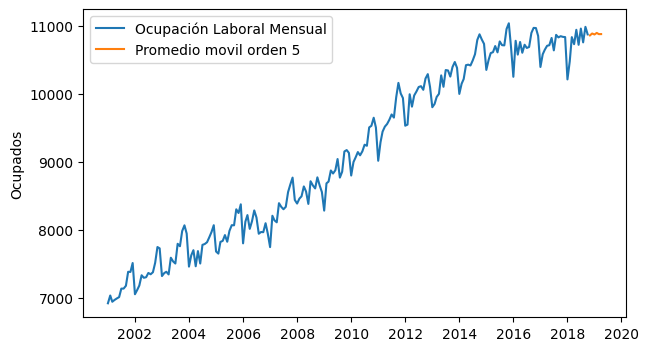

In [ ]:
fig = plt.figure(figsize=(7, 4))
plt.plot(train_td,label="Ocupación Laboral Mensual")
plt.plot(ma_5_f,label="Promedio movil orden 5")
plt.ylabel("Ocupados")
plt.legend()
plt.show()

Utilizando el método de Promedio Móvil, se obtuvo el menor RMSE de 291.017 con
𝑘 =5. En el gráfico, se pueden observar los valores pronosticados mediante este método, los cuales parecen ignorar la tendencia creciente de los datos.

### **2.2 Suavizacion Exponencial Simple**

In [ ]:
# Build model.

ets_model = ETSModel(endog=train_td["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6) #Pronóstico tomando 6 valores (meses)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


#Data frame con resultados
preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-11-01    10890.815856  10535.182689  11246.449022
2018-12-01    10890.815856  10469.673459  11311.958252
2019-01-01    10890.815856  10413.063946  11368.567765
2019-02-01    10890.815856  10362.485602  11419.146109
2019-03-01    10890.815856  10316.343206  11465.288506
2019-04-01    10890.815856  10273.641006  11507.990705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


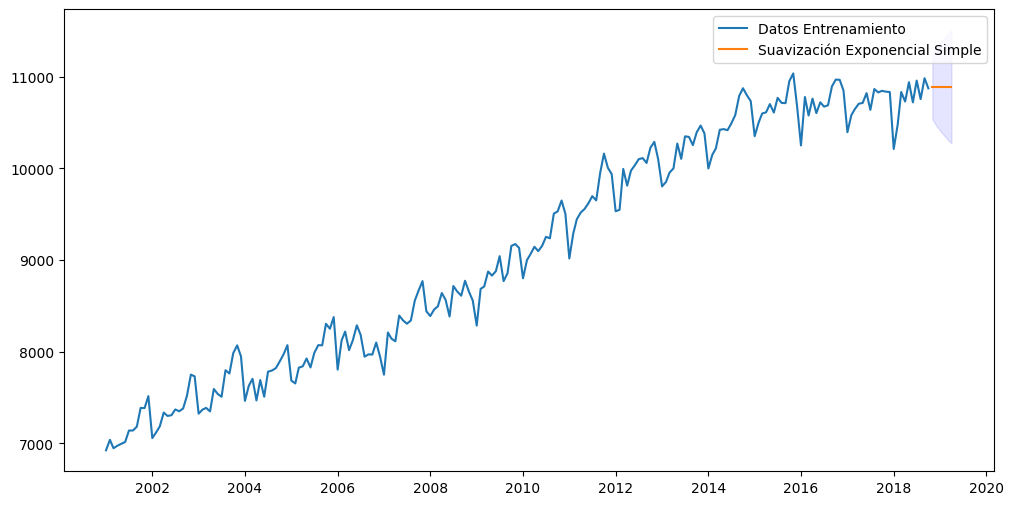

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
ets_result.alpha

0.6343030045478203

In [ ]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

300.4290298412983


Utilizando el método Suavización exponencial simple, se obtuvo un RMSE de 300.429, superando el RMSE de 291.017 obtenido mediante Promedio simple.  En el gráfico, se pueden observar los valores pronosticados mediante este método, los cuales, al igual que en el Promedio Simple, ignoran la tendencia creciente de los datos.

En el gráfico y tabla de los valores predichos, se observa además, un valor de predicción constante para la tasa de ocupación laboral con intervalos de confianza que se amplían con el tiempo, indicando una mayor incertidumbre en las predicciones a medida que se avanza hacia el futuro.

### **2.3 Suavizacion Exponencial Lineal (Holt)**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10932.699204  10500.504995  11341.433024
2018-12-01    10956.943685  10467.397144  11442.024353
2019-01-01    10981.241931  10429.997127  11501.078708
2019-02-01    11005.594061  10410.171865  11541.612615
2019-03-01    11030.000195  10405.334296  11625.020836
2019-04-01    11054.460452  10330.732846  11739.876865


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10922.345053  10523.362820  11356.362738
2018-12-01    10941.164971  10469.612377  11431.127520
2019-01-01    10959.984890  10439.377409  11553.430052
2019-02-01    10978.804809  10381.072212  11631.168331
2019-03-01    10997.624728  10345.381375  11683.357422
2019-04-01    11016.444647  10389.210895  11775.013885


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10927.114148  10579.574023  11286.567555
2018-12-01    10948.230528  10560.535601  11341.440432
2019-01-01    10969.387716  10550.047362  11413.989594
2019-02-01    10990.585789  10513.043345  11478.368780
2019-03-01    11011.824827  10477.080868  11526.770598
2019-04-01    11033.104908  10484.602366  11602.226370


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10921.837423  10568.380806  11275.294041
2018-12-01    10940.275438  10532.003993  11348.546883
2019-01-01    10958.713453  10501.184691  11416.242215
2019-02-01    10977.151468  10474.277712  11480.025224
2019-03-01    10995.589483  10450.297487  11540.881479
2019-04-01    11014.027498  10428.599401  11599.455595


<ipython-input-259-3d3928275ab8>:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path) ###Leyendo cada imagen


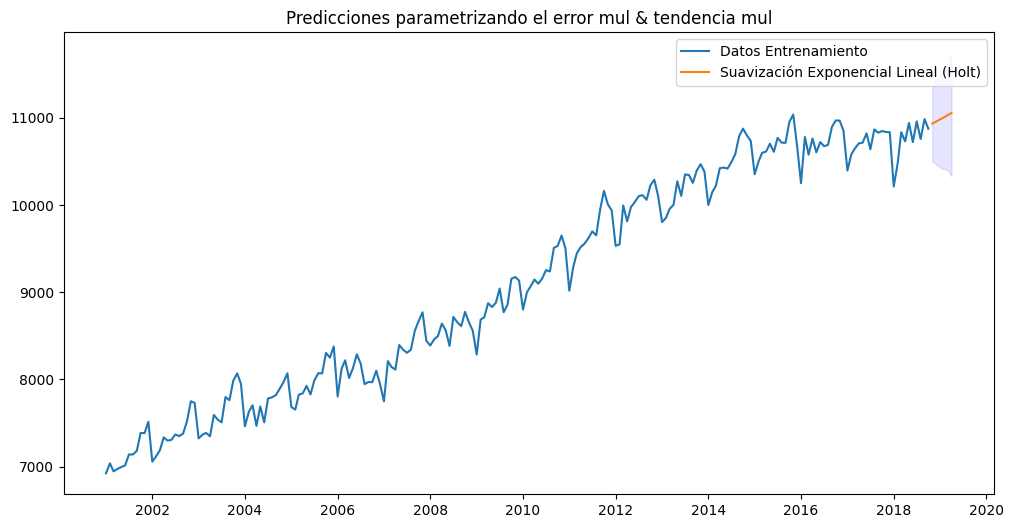

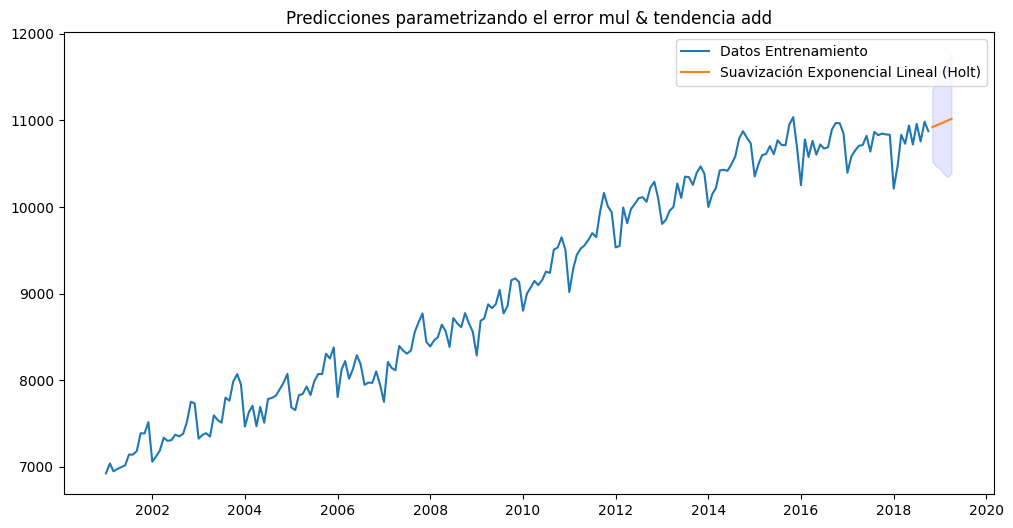

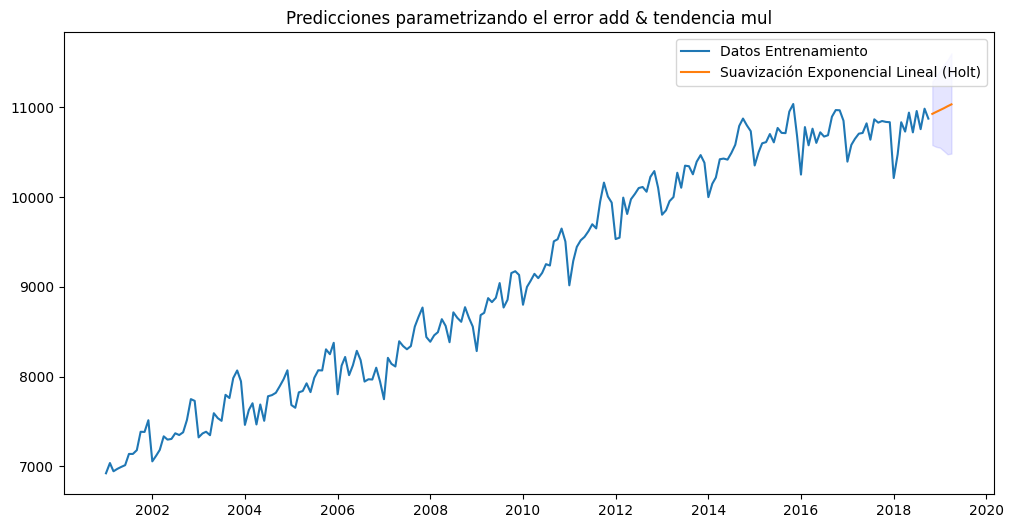

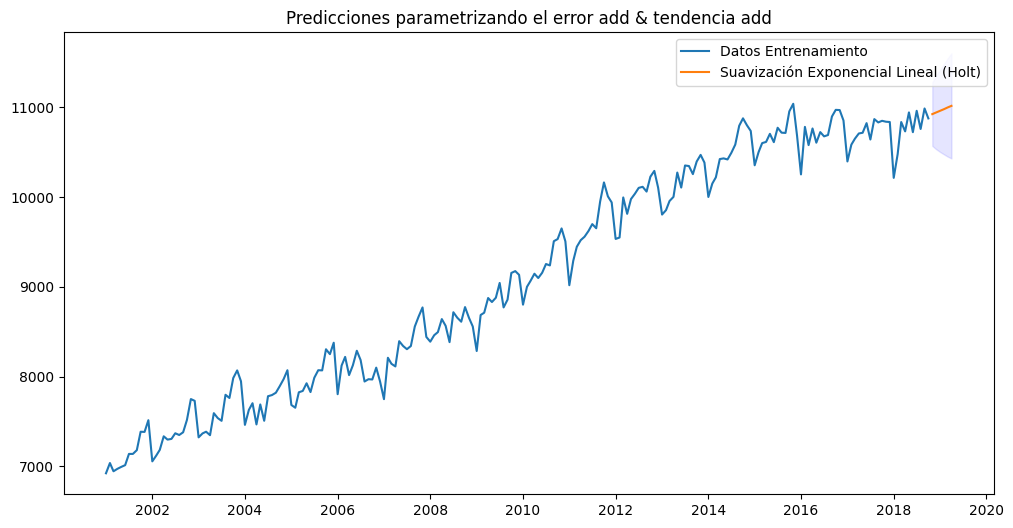

In [ ]:
# Construimos el modelo parametrizando el error y la tendencia.
error = ['mul', 'add'] #diccionario de errores
trend = ['mul', 'add'] # diccionario de tendencias
index = 1
paths = []
param = []
caso = []

#Construimos un loop para recorrer todas las posibles combinaciones del tratamiento del error y la tendencia
for e in error:
    for t in trend:
        ets_model = ETSModel(endog=train_td["Ocupados"],error=e,trend=t)#,seasonal="mul" )
        ets_result = ets_model.fit()

        point_forecast=ets_result.forecast(6)

        ci = ets_result.get_prediction(start = point_forecast.index[0],
                                        end = point_forecast.index[-1])

        conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
        limits = ci.predicted_mean

        caso.append([[e, t]])

        preds_holt = pd.concat([limits, conf_forecast], axis = 1)
        preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
        rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
        print(preds_holt)
        fig = plt.figure(figsize=(12, 6))
        plt.plot(train_td,label="Datos Entrenamiento")
        plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
        plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
        plt.title(f'Predicciones parametrizando el error {e} & tendencia {t}')
        plt.legend()
        path = f'./images/{index}.png' #Creando una ruta para la imagen
        paths.append(path) #Guardando la ruta en una lista
        plt.savefig(path) #Guardando imagen en la ruta y nombre especifico creado en 'path'
        index = index + 1

        param.append([ets_result.alpha,ets_result.beta, rmse_holt])

import imageio

with imageio.get_writer('suavizacionHolt.gif', mode ='I', duration = 750) as gif:
    for path in paths:
        image = imageio.imread(path) ###Leyendo cada imagen
        gif.append_data(image)


In [ ]:
param

[[0.5483136299154637, 5.483136299154638e-05, 394.349010523351],
 [0.5782798563009995, 0.0059447650969084035, 371.54436053379465],
 [0.5450401812292424, 5.450401812292424e-05, 381.54588770018285],
 [0.571963780298305, 0.006149418787101443, 370.1579750635174]]

In [ ]:
parametros_holt = pd.DataFrame(param,columns=['alpha','beta','rmse'])
casos_holt = pd.DataFrame(caso,columns=['caso (e/t)'])
reporte_holt = pd.concat([casos_holt,parametros_holt],axis=1)
reporte_holt.index = reporte_holt['caso (e/t)']
reporte_holt = reporte_holt.drop('caso (e/t)',axis=1)
reporte_holt

,alpha,beta,rmse
caso (e/t),,,
"[mul, mul]",0.548314,0.000055,394.349011
"[mul, add]",0.578280,0.005945,371.544361
"[add, mul]",0.545040,0.000055,381.545888
"[add, add]",0.571964,0.006149,370.157975


Utilizando el método Suavización exponencial lineal (Holt), se obtuvo un RMSE de 394.349, superando el RMSE de 300.429 obtenido mediante Promedio simple y el RMSE de 291.017 obtenido mediante Suavización exponencial simple. En el gráfico, se pueden observar los valores pronosticados mediante este método, los cuales sí consideran la tendencia creciente de los datos.

En el gráfico y tabla de los valores predichos, se observa además, un valor de predicción constante para la tasa de ocupación laboral con intervalos de confianza que se amplían con el tiempo, indicando una mayor incertidumbre en las predicciones a medida que se avanza hacia el futuro.

## **2.4 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

Procedemos a entrenar el modelo recorriendo las distintas posibilidades de combinación de los métodos para los hiperparámetros

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11033.581257  10732.950798  11322.369088
2018-12-01    10942.727403  10626.668829  11266.438653
2019-01-01    10484.708226  10133.275788  10822.043319
2019-02-01    10700.715123  10303.898168  11058.920744
2019-03-01    10793.772817  10382.324326  11206.414642
2019-04-01    10814.558144  10370.513568  11272.025004


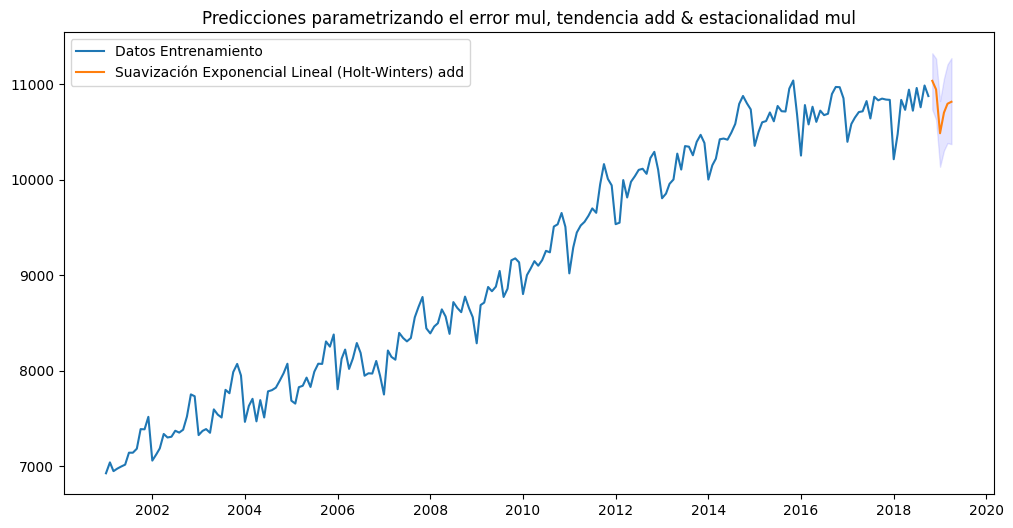

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11020.412574  10699.674717  11341.498116
2018-12-01    10918.631490  10580.057727  11262.366449
2019-01-01    10430.597045  10094.205242  10772.439304
2019-02-01    10709.637041  10357.896586  11095.550128
2019-03-01    10860.927613  10479.249413  11244.532532
2019-04-01    10869.560918  10456.944668  11284.186311


<Figure size 640x480 with 0 Axes>

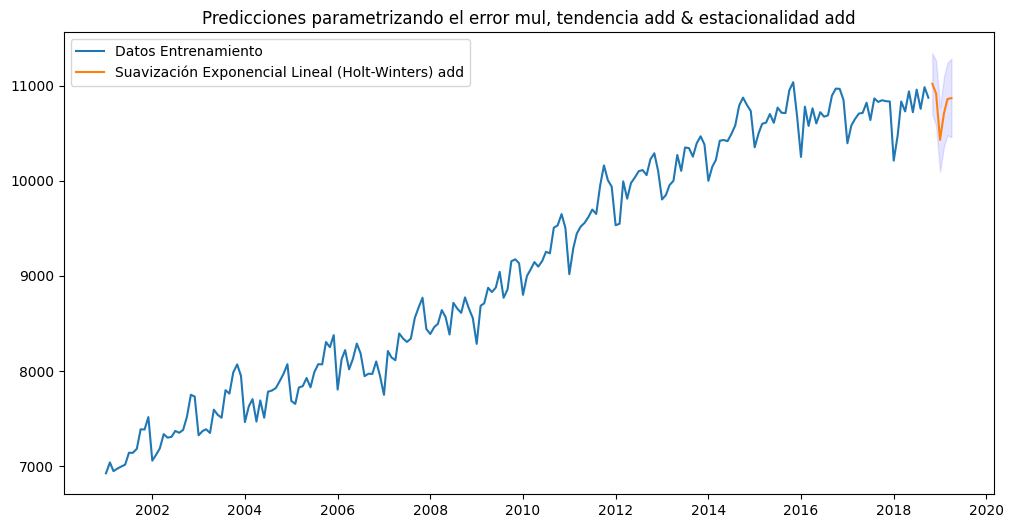

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10979.936845  10683.970792  11247.009804
2018-12-01    10867.570947  10512.572448  11191.691571
2019-01-01    10387.242052  10012.798686  10752.239824
2019-02-01    10586.106381  10178.604295  10963.296853
2019-03-01    10658.624059  10190.661958  11083.568987
2019-04-01    10659.417809  10168.786200  11134.818492


<Figure size 640x480 with 0 Axes>

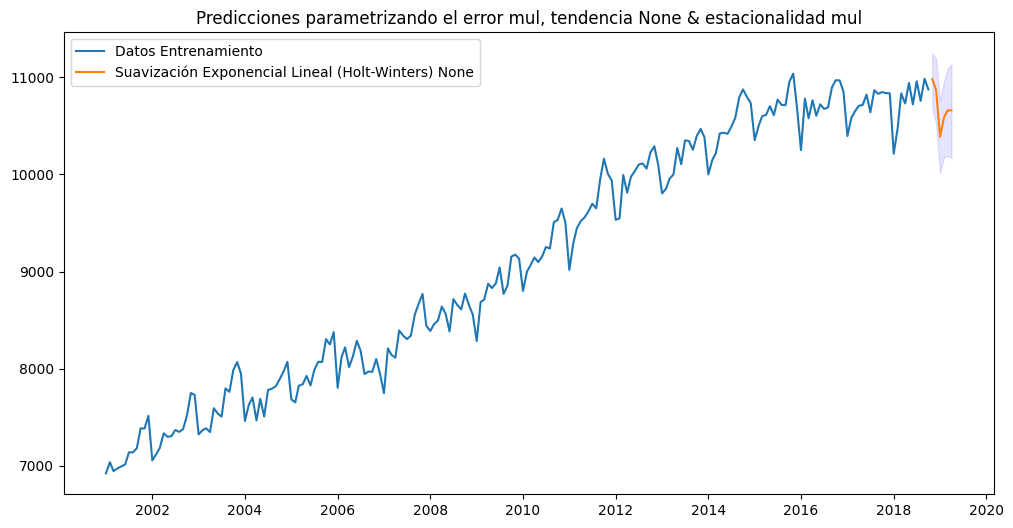

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10961.155224  10668.293805  11253.535075
2018-12-01    10873.827753  10528.870312  11200.061054
2019-01-01    10483.551035  10104.672007  10840.979365
2019-02-01    10644.650169  10245.783760  11055.039162
2019-03-01    10700.113527  10250.119862  11145.035007
2019-04-01    10699.756364  10220.119095  11179.965535


<Figure size 640x480 with 0 Axes>

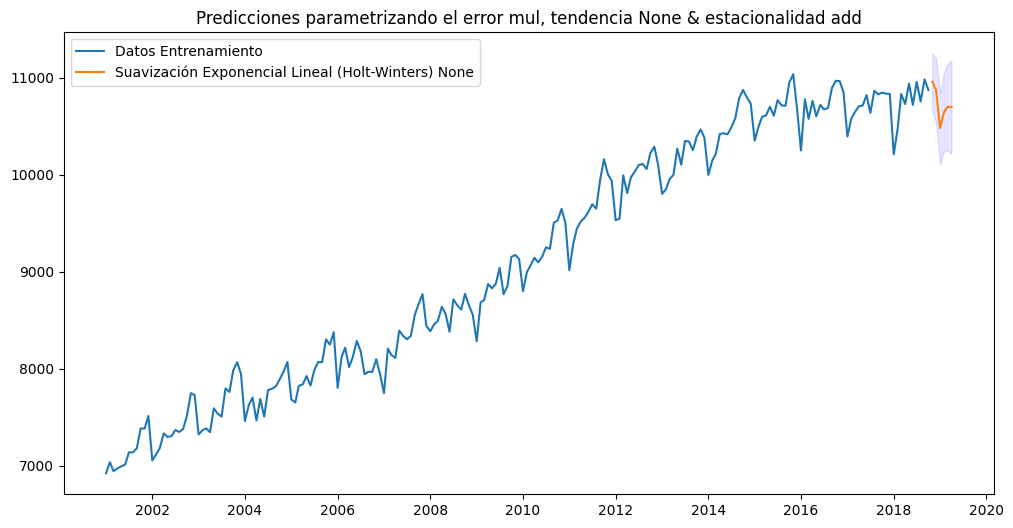

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11033.314201  10751.588225  11325.768067
2018-12-01    10941.667798  10600.349992  11244.714434
2019-01-01    10481.956092  10154.990073  10810.046147
2019-02-01    10698.260889  10323.511510  11091.962043
2019-03-01    10791.000570  10402.304354  11188.414745
2019-04-01    10811.523619  10381.264448  11207.296887


<Figure size 640x480 with 0 Axes>

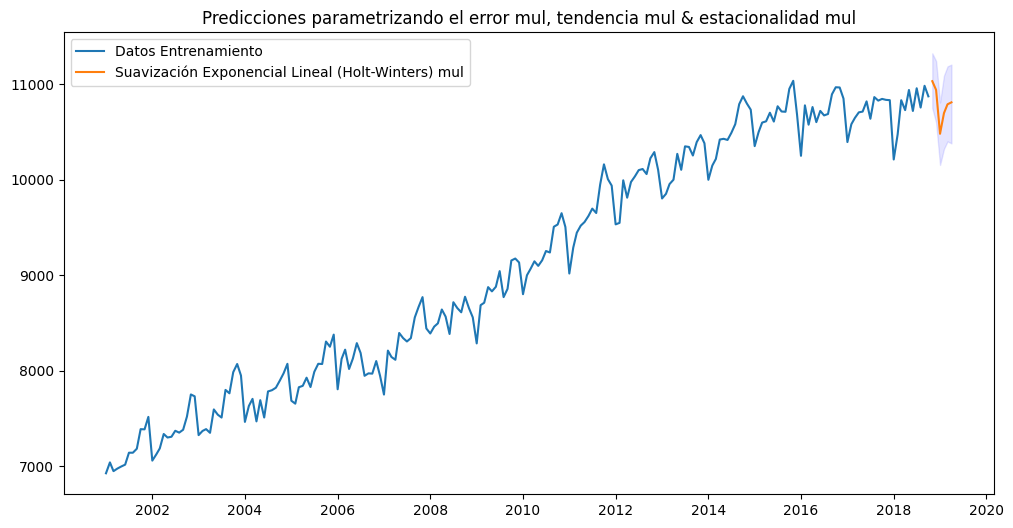

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11052.042881  10665.523728  11454.729055
2018-12-01    10976.359576  10563.611121  11388.891587
2019-01-01    10464.205848  10029.597388  10896.838930
2019-02-01    10753.075830  10307.969564  11210.751278
2019-03-01    10932.161752  10460.309103  11358.100794
2019-04-01    10913.766433  10434.270191  11391.260797


<Figure size 640x480 with 0 Axes>

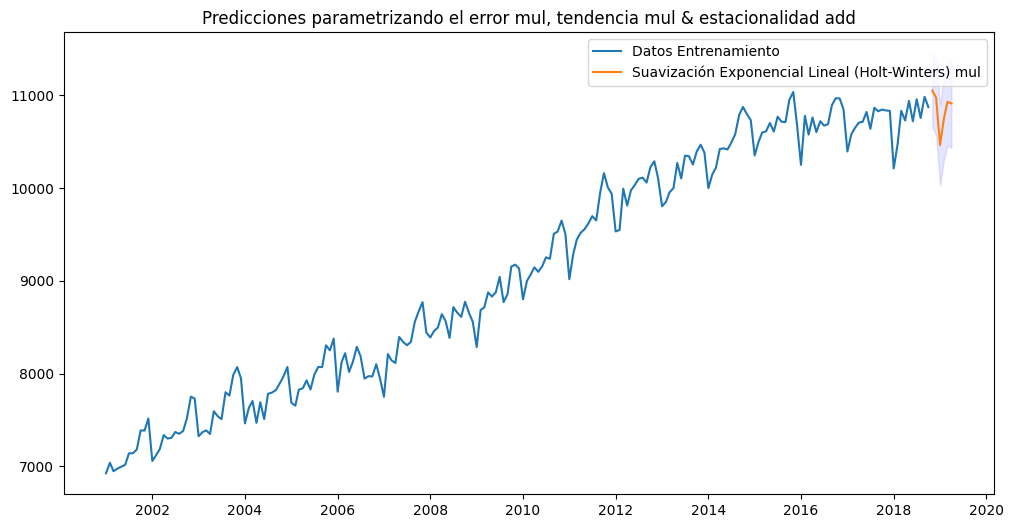

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11027.470105  10811.793762  11244.530969
2018-12-01    10921.685157  10653.670855  11173.896193
2019-01-01    10472.005916  10211.354245  10753.023475
2019-02-01    10691.000571  10417.142544  11006.759355
2019-03-01    10793.959412  10469.564222  11110.826028
2019-04-01    10821.997308  10466.721934  11168.724887


<Figure size 640x480 with 0 Axes>

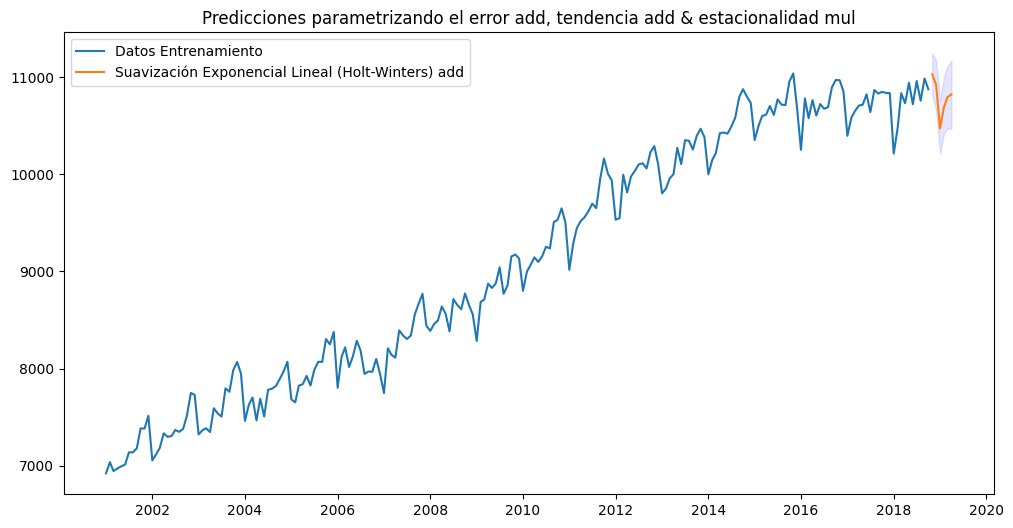

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11016.615370  10758.765337  11274.465403
2018-12-01    10910.345328  10638.016873  11182.673784
2019-01-01    10431.804223  10145.726486  10717.881959
2019-02-01    10707.064097  10407.865684  11006.262509
2019-03-01    10853.107263  10541.337405  11164.877121
2019-04-01    10868.686776  10544.830737  11192.542816


<Figure size 640x480 with 0 Axes>

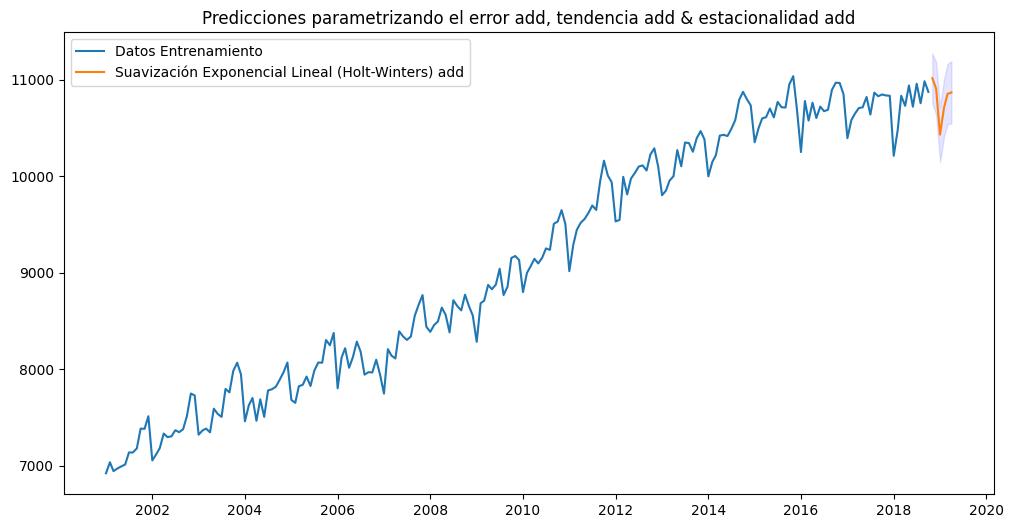

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10974.856321  10762.945688  11209.833297
2018-12-01    10849.851832  10578.859691  11127.027279
2019-01-01    10377.100978  10085.441757  10677.034317
2019-02-01    10579.686260  10269.090910  10920.257756
2019-03-01    10663.322195  10326.076452  11044.534114
2019-04-01    10672.646077  10312.897138  11068.033288


<Figure size 640x480 with 0 Axes>

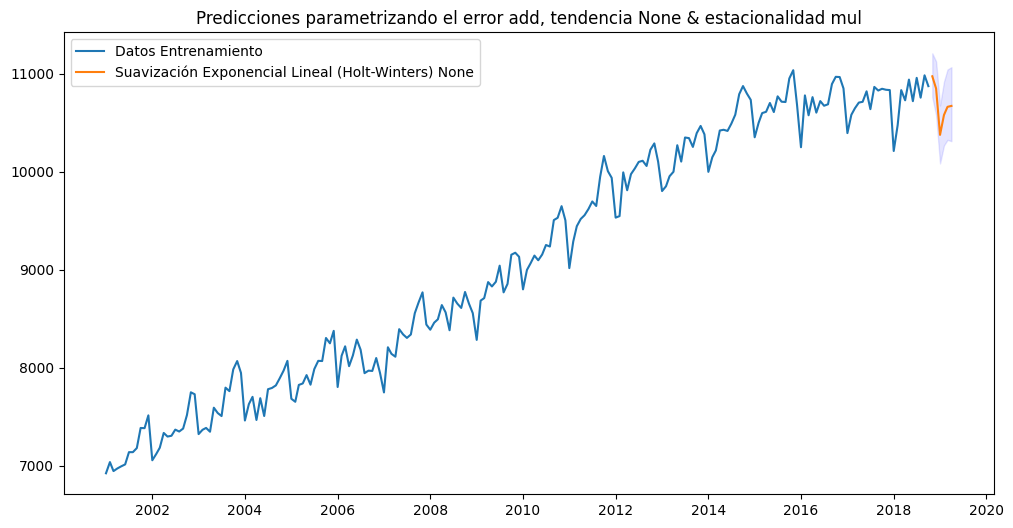

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    10939.323634  10669.740315  11208.906952
2018-12-01    10809.510513  10511.299967  11107.721059
2019-01-01    10305.733143   9981.412478  10630.053808
2019-02-01    10576.618538  10228.138614  10925.098462
2019-03-01    10710.728207  10339.658642  11081.797771
2019-04-01    10708.197446  10315.836661  11100.558231


<Figure size 640x480 with 0 Axes>

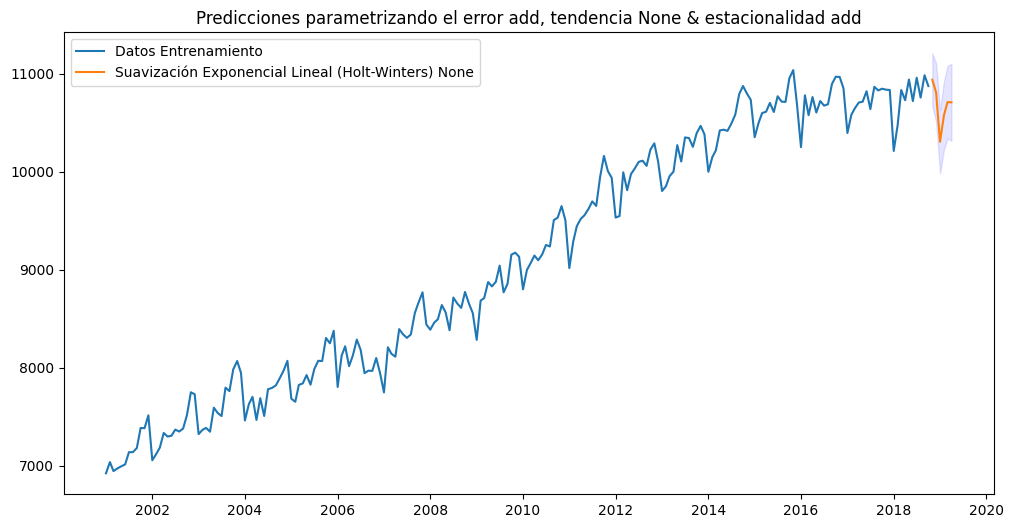

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11026.870678  10800.823143  11250.432630
2018-12-01    10920.662768  10669.070639  11185.637210
2019-01-01    10469.148802  10213.551592  10731.859219
2019-02-01    10688.761500  10392.352893  10972.609040
2019-03-01    10791.756854  10475.407119  11107.913289
2019-04-01    10819.743914  10478.937374  11140.801763


<Figure size 640x480 with 0 Axes>

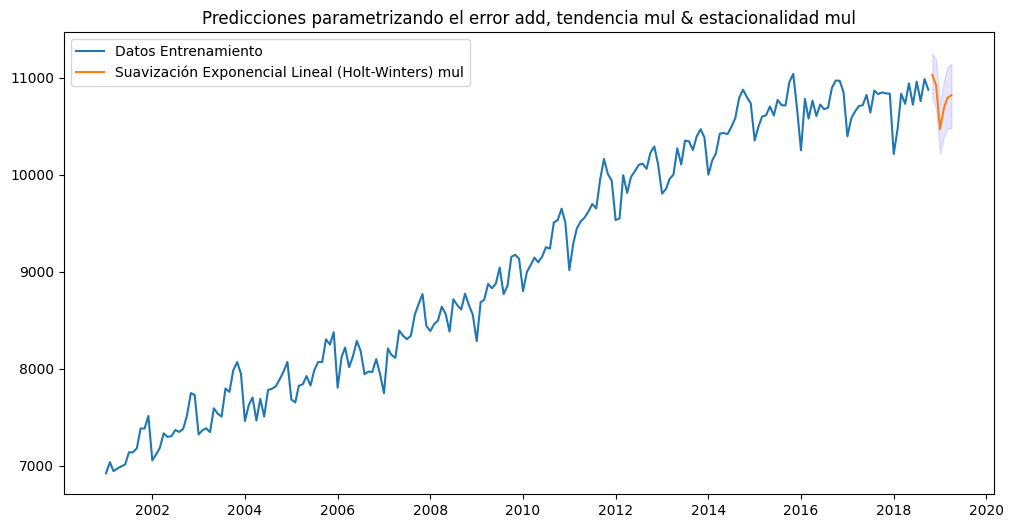

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-11-01    11021.454009  10704.652210  11315.092531
2018-12-01    10923.952572  10608.721415  11271.330981
2019-01-01    10430.847684  10076.127515  10783.963970
2019-02-01    10714.866687  10322.727554  11084.925217
2019-03-01    10869.083615  10468.931566  11254.433922
2019-04-01    10871.565260  10448.881744  11297.978021


<Figure size 640x480 with 0 Axes>

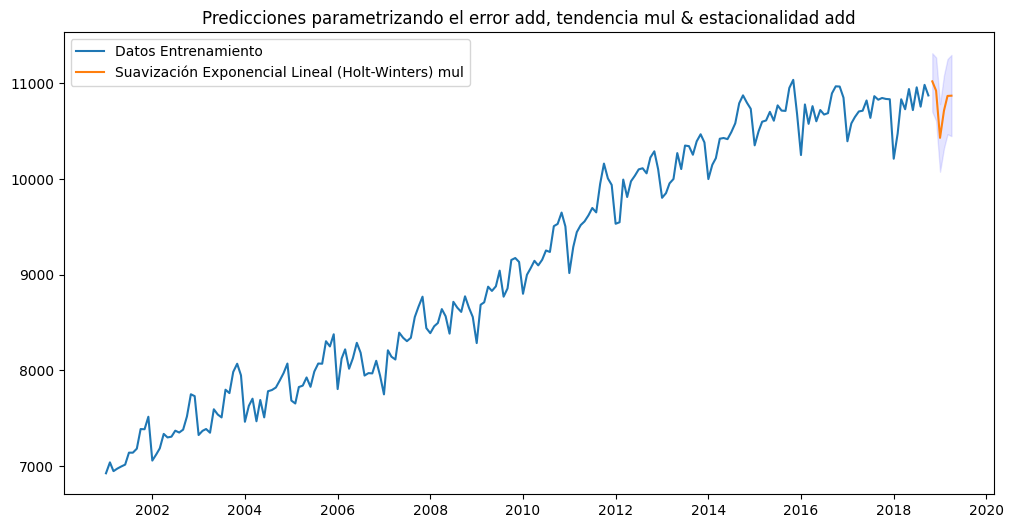

<ipython-input-314-b529ff12da99>:56: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path) ###Leyendo cada imagen


<Figure size 640x480 with 0 Axes>

In [314]:
# Construimos el modelo parametrizando el error y la tendencia.
error = ['mul', 'add'] #diccionario de errores
trend = ['add', None, 'mul'] # diccionario de tendencias
seasonal = ['mul', 'add'] # diccionario de estacionalidad
index = 1
paths = []
param = []
caso= []


#Construimos un loop para
for e in error:
    for t in trend:
        for s in seasonal:
          # Build model
          ets_model = ETSModel(endog=train_td["Ocupados"],error=f'{e}', trend=t,seasonal=f'{s}' )
          ets_result = ets_model.fit()

          point_forecast=ets_result.forecast(6)

          ci = ets_result.get_prediction(start = point_forecast.index[0],
                                          end = point_forecast.index[-1])

          conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
          limits = ci.predicted_mean

          caso.append([[e, t, s]])

          preds_hw = pd.concat([limits, conf_forecast], axis = 1)
          preds_hw.columns = ['Point_forecast', 'lower_95', 'upper_95']
          rmse_hw= np.sqrt(mean_squared_error(test_td,preds_hw['Point_forecast']))
          print(preds_hw)
          fig = plt.figure(figsize=(12, 6))
          plt.plot(train_td,label="Datos Entrenamiento")
          plt.plot(preds_hw['Point_forecast'],label=f"Suavización Exponencial Lineal (Holt-Winters) {t}")
          plt.fill_between(preds_hw.index ,preds_hw['lower_95'], preds_hw['upper_95'], color='blue', alpha=0.1)
          plt.title(f'Predicciones parametrizando el error {e}, tendencia {t} & estacionalidad {s}')
          plt.legend()
          plt.show()

          path = f'./images/hw/{index}.png' #Creando una ruta para la imagen
          paths.append(path) #Guardando la ruta en una lista
          plt.savefig(path) #Guardando imagen en la ruta y nombre especifico creado en 'path'
          index = index + 1
          if t == None:
            param.append([ets_result.alpha, 'None', ets_result.gamma, rmse_hw])
          else:
            param.append([ets_result.alpha, ets_result.beta, ets_result.gamma, rmse_hw])



import imageio

with imageio.get_writer('suavizacionHoltWinters.gif', mode ='I', duration = 750) as gif:
    for path in paths:
        image = imageio.imread(path) ###Leyendo cada imagen
        gif.append_data(image)


In [319]:
parametros_hw = pd.DataFrame(param,columns=['alpha','beta','gamma','rmse'])
casos_hw = pd.DataFrame(caso,columns=['caso (e/t/s)'])
reporte_hw = pd.concat([casos_hw,parametros_hw],axis=1)
reporte_hw.index = reporte_hw['caso (e/t/s)']
reporte_hw = reporte_hw.drop('caso (e/t/s)',axis=1)
round(reporte_hw,6)

,alpha,beta,gamma,rmse
caso (e/t/s),,,,
"[mul, add, mul]",0.550834,0.000331,0.000045,162.249862
"[mul, add, add]",0.348970,0.000035,0.326139,166.390499
"[mul, None, mul]",0.623238,None,0.000038,97.452409
"[mul, None, add]",0.611949,None,0.000039,113.650495
"[mul, mul, mul]",0.546585,0.000055,0.000045,160.567634
"[mul, mul, add]",0.306331,0.002576,0.425175,208.710500
"[add, add, mul]",0.513366,0.001316,0.000049,156.414707
"[add, add, add]",0.339751,0.000034,0.301365,163.608148
"[add, None, mul]",0.595512,None,0.000040,93.497542


##**3. Entrenamiento del Mejor modelo**

Entrenamiento del modelo Holt - Winters aditivo determinando los mejores hiperparámetros encontrados en el punto anterior

In [322]:
# Build model.
final_model = ETSModel(endog=data["Ocupados"],error="add",trend=None,seasonal="add" )
final_result = final_model.fit_constrained({'smoothing_level': 0.472925,'smoothing_seasonal': 0.299519})

point_forecast=final_result.forecast(6)

ci = final_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2019-05-01    10758.215528  10504.607517  11011.823540
2019-06-01    10698.762668  10418.223822  10979.301514
2019-07-01    10774.601790  10469.500062  11079.703518
2019-08-01    10750.146213  10422.316860  11077.975567
2019-09-01    10863.040653  10513.960282  11212.121024
2019-10-01    10867.780148  10498.670238  11236.890059


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [334]:
pd.options.display.float_format = '{:,.2f}'.format
round(preds_hw_add,2)

,Point_forecast,lower_95,upper_95
2019-05-01,"10,758.22","10,504.61","11,011.82"
2019-06-01,"10,698.76","10,418.22","10,979.30"
2019-07-01,"10,774.60","10,469.50","11,079.70"
2019-08-01,"10,750.15","10,422.32","11,077.98"
2019-09-01,"10,863.04","10,513.96","11,212.12"
2019-10-01,"10,867.78","10,498.67","11,236.89"


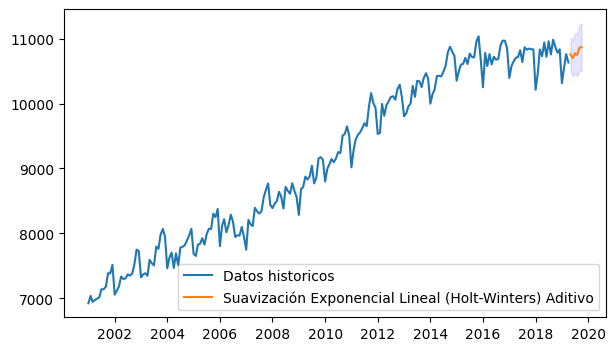

In [324]:
fig = plt.figure(figsize=(7, 4))
plt.plot(data['Ocupados'],label="Datos historicos")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [330]:
print(final_result.alpha,final_result.gamma)

0.472925 0.299519


##**4. Conclusiones**

El método de Suavización Exponencial de Holt Winters con enfoque aditivo ofreció el mejor desempeño para los datos analizados. Los parámetros obtenidos indican una alta capacidad de respuesta a cambios en la serie temporal y los resultados resaltan la importancia de seleccionar el método adecuado para capturar el comportamiento de los datos